In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import shutil
from fastai.vision.all import *
from scipy.fft import fft, ifft
from scipy import interpolate
from scipy.signal import butter, filtfilt

srate = 220  # Sampling rate

# ----------- Filtering Function ----------- #
def bandpass_filter(signal, lowcut=1.0, highcut=40.0, fs=220, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

# ----------- Resample Function ----------- #
def resample_array(array, target_length):
    input_indices = np.linspace(0, len(array) - 1, len(array))
    resampled_indices = np.linspace(0, len(array) - 1, target_length)
    interpolator = interpolate.interp1d(input_indices, array)
    return interpolator(resampled_indices).tolist()

# ----------- Create Morlet Wavelets ----------- #
def get_cmwX(nData, freqrange=[1, 6], numfrex=10):
    pi = np.pi
    wavtime = np.arange(-2, 2 - 1/srate, 1/srate)
    nKern = len(wavtime)
    nConv = nData + nKern - 1
    frex = np.linspace(freqrange[0], freqrange[1], numfrex)
    cmwX = np.zeros((numfrex, nConv), dtype=complex)
    numcyc = np.linspace(3, 15, numfrex)

    for fi in range(numfrex):
        s = numcyc[fi] / (2 * pi * frex[fi])
        cmw = np.exp(2j * pi * frex[fi] * wavtime) * np.exp((-wavtime**2) / (2 * s**2))
        cmwX[fi, :] = fft(cmw, nConv) / max(fft(cmw, nConv))
    return cmwX, nKern, frex

# ----------- Time-Frequency Analysis ----------- #
def time_frequency(data, cmwX, nKern):
    nData = data.shape[1]
    nConv = nData + nKern - 1
    halfwav = (nKern - 1) // 2
    tf = np.zeros((data.shape[0], cmwX.shape[0], data.shape[1]))
    for ch in range(data.shape[0]):
        eegX = fft(data[ch, :], nConv)
        as_ = ifft(cmwX * eegX[None, :], axis=1)
        tf[ch, :, :] = np.abs(as_[:, halfwav:-halfwav]) ** 2
    return tf

# ----------- Load Data ----------- #
mnist_path = 'rC:\Users\admin\Downloads\MindBigData-MU-v1.0\MU.txt'
mnist_df = pd.read_csv(mnist_path, sep='\t', header=None, nrows=5000)
mnist_df.columns = ['id', 'event_id', 'device', 'channel', 'code', 'size', 'data']
resting_df = pd.read_csv(mnist_path, sep='\t', names=mnist_df.columns, header=None, skiprows=130000, nrows=5000)
df = pd.concat([mnist_df, resting_df])
df['data'] = df['data'].apply(lambda x: [float(i) for i in x.split(',')])
df['data'] = df['data'].apply(lambda x: bandpass_filter(np.array(x)))

# ----------- Resample ----------- #
median_length = 459
df['resampled_data'] = df['data'].apply(lambda x: resample_array(x, median_length))
data_array = np.array(df['resampled_data'].tolist())
codes = df['code'].tolist()
data_array = data_array.reshape(-1, 4, median_length)
data_array = np.mean(data_array, axis=1)
codes = codes[::4]

# ----------- Time-Frequency Plot Creation ----------- #
times = np.linspace(0, 2, median_length)
cmwX, nKern, frex = get_cmwX(data_array.shape[1])
tf = time_frequency(data_array, cmwX, nKern)

# ----------- Modified get_path function ----------- #
def get_path(i, path, code, total_samples):
    train_ratio = 0.7
    train_cutoff = int(total_samples * train_ratio)
    if i < train_cutoff:
        return f"{path}training/{code}"
    else:
        return f"{path}test/{code}"




In [12]:
import os

def print_image_counts(path):
    for label in sorted(os.listdir(path)):
        label_path = os.path.join(path, label)
        if os.path.isdir(label_path):
            count = len([f for f in os.listdir(label_path) if f.endswith('.png')])
            print(f"Label {label}: {count} images")

print("✅ Test set counts:")
print_image_counts(r'C:\Users\admin\Downloads\images-20250610T055446Z-1-001\balanced_dataset')




✅ Test set counts:
Label 0: 1006 images
Label 1: 1339 images
Label 2: 1257 images
Label 3: 1257 images
Label 4: 1255 images
Label 5: 1251 images
Label 6: 1257 images
Label 7: 1255 images
Label 8: 1261 images
Label 9: 1253 images


In [13]:
import os

def print_image_counts(path):
    for label in sorted(os.listdir(path)):
        label_path = os.path.join(path, label)
        if os.path.isdir(label_path):
            count = len([f for f in os.listdir(label_path) if f.endswith('.png')])
            print(f"Label {label}: {count} images")

print("✅ Test set counts:")
print_image_counts(r'C:\Users\admin\Downloads\images-20250610T055446Z-1-001\images\test')




✅ Test set counts:
Label 0: 106 images
Label 1: 102 images
Label 2: 105 images
Label 3: 105 images
Label 4: 104 images
Label 5: 101 images
Label 6: 105 images
Label 7: 104 images
Label 8: 107 images
Label 9: 103 images


epoch,train_loss,valid_loss,accuracy,time
0,2.298638,1.221462,0.630751,02:23


epoch,train_loss,valid_loss,accuracy,time
0,1.405501,0.798514,0.770379,02:36
1,1.087700,0.680957,0.797821,02:36
2,0.881624,0.652032,0.812752,02:39
3,0.767862,0.641337,0.825666,02:36
4,0.723237,0.648417,0.824052,02:37
5,0.693173,0.657557,0.831719,02:36
6,0.664922,0.645969,0.830105,02:38
7,0.626381,0.657157,0.824455,02:36
8,0.576543,0.655294,0.829298,02:37
9,0.573436,0.639360,0.829298,02:39


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

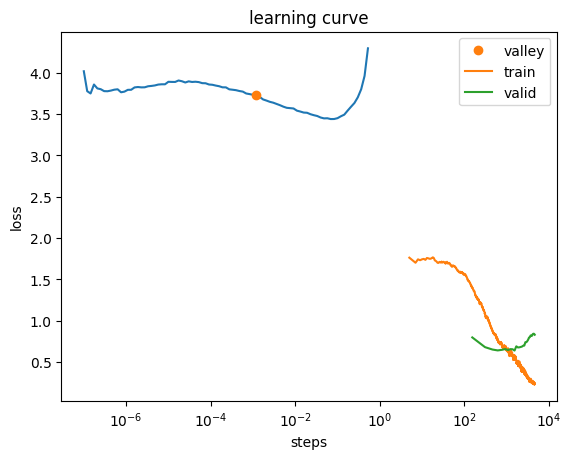

In [20]:
from fastai.vision.all import *

# Set path to the dataset
path = Path(r"C:\Users\admin\Downloads\images-20250610T055446Z-1-001\balanced_dataset")

# Create DataLoaders
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,
    seed=42,  # ensures reproducibility
    item_tfms=Resize(460),   # resize before augmentations
    batch_tfms=aug_transforms(size=224)  # apply data augmentation
)

# Create learner with ResNet-50
learn = vision_learner(dls, resnet50, metrics=accuracy)

# Find a good learning rate (optional but recommended)
learn.lr_find()

# Fine-tune model for 30 epochs
learn.fine_tune(30, base_lr=3e-3)

# Plot training/validation loss after training
learn.recorder.plot_loss()


In [21]:
# Evaluate on test set
test_path = r"C:\Users\admin\Downloads\images-20250610T055446Z-1-001\images\test"
test_files = get_image_files(test_path)
test_dl = learn.dls.test_dl(test_files, with_labels=True)
loss, acc = learn.validate(dl=test_dl)
print(f"Test Accuracy: {acc*100:.2f}%")

Test Accuracy: 63.53%


In [22]:
from fastai.vision.all import *

# Get predictions on test set
preds, targs = learn.get_preds(dl=test_dl)

# Convert predictions to labels
pred_labels = preds.argmax(dim=1)

# Accuracy
correct = (pred_labels == targs).sum().item()
total = len(targs)
acc = correct / total

print(f"Correct Predictions: {correct}/{total}")
print(f"Calculated Accuracy: {acc * 100:.2f}%")


Correct Predictions: 662/1042
Calculated Accuracy: 63.53%


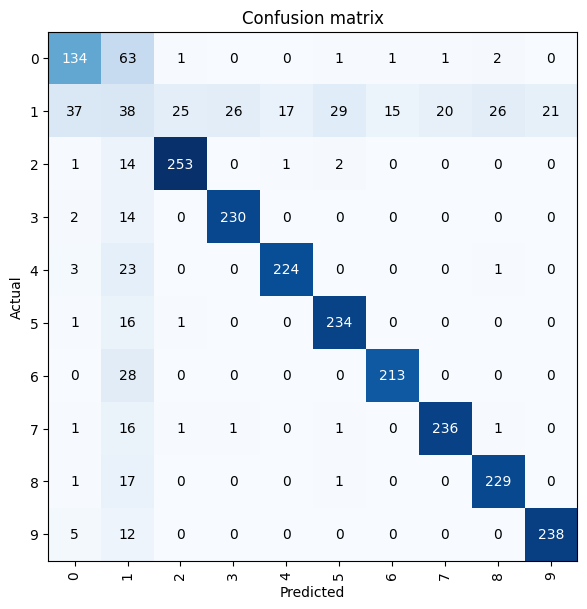

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,6))

In [24]:
from sklearn.metrics import classification_report

# Get predictions and true labels
preds, y_true = learn.get_preds(dl=test_dl)
y_pred = preds.argmax(dim=1)

# Class labels (0 to 9)
target_names = [str(i) for i in range(10)]

# Print classification report
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       106
           1       0.13      0.41      0.20       102
           2       0.89      0.60      0.72       105
           3       0.89      0.69      0.77       105
           4       0.88      0.64      0.74       104
           5       0.75      0.59      0.66       101
           6       0.84      0.50      0.62       105
           7       0.95      0.60      0.73       104
           8       0.81      0.65      0.73       107
           9       0.94      0.66      0.78       103

    accuracy                           0.64      1042
   macro avg       0.79      0.63      0.69      1042
weighted avg       0.80      0.64      0.69      1042



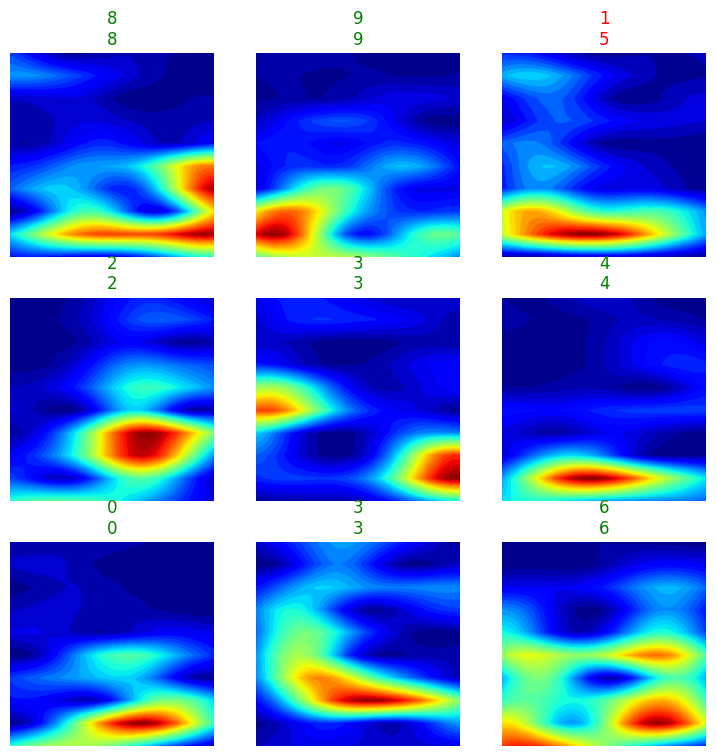

In [26]:
learn.show_results()